In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

Load Data

In [4]:
(train_ds,train_labels),(test_ds,test_labels)=tfds.load("tf_flowers",split=["train[:70%]","train[:30%]"],
                                                       batch_size=-1,
                                                       as_supervised=True,
                                                       )

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Image Preprocessing

In [5]:
train_ds[0].shape

TensorShape([442, 1024, 3])

In [6]:
train_ds=tf.image.resize(train_ds,(150,150))
test_ds=tf.image.resize(test_ds,(150,150))

In [7]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0])>

In [8]:
train_labels=to_categorical(train_labels,num_classes=5)
test_labels=to_categorical(test_labels,num_classes=5)

In [9]:
train_labels[0]

array([0., 0., 1., 0., 0.], dtype=float32)

Use pretrained VGG16 Image Classification Model

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [11]:
train_ds[0].shape

TensorShape([150, 150, 3])

In [12]:
base_model=VGG16(weights="imagenet",include_top=False,input_shape=train_ds[0].shape)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
base_model.trainable=False

In [14]:
train_ds=preprocess_input(train_ds)
test_ds=preprocess_input(test_ds)

In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [16]:
from tensorflow.keras import layers,models

flatten_layer=layers.Flatten()
dense_layer_1=layers.Dense(50,activation='relu')
dense_layer_2=layers.Dense(20,activation='relu')
prediction_layer=layers.Dense(5,activation='softmax')

model=models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

Train classifier layers on training data available for task

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [20]:
es=EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)

In [21]:
history=model.fit(train_ds,train_labels,epochs=10,validation_split=0.2,batch_size=32,callbacks=[es])

Epoch 1/10
65/65 [==============================] - 643s 10s/step - loss: 0.6158 - accuracy: 0.7635 - val_loss: 1.0595 - val_accuracy: 0.6479
Epoch 2/10
65/65 [==============================] - 627s 10s/step - loss: 0.4134 - accuracy: 0.8438 - val_loss: 1.1003 - val_accuracy: 0.6712
Epoch 3/10
65/65 [==============================] - 627s 10s/step - loss: 0.3064 - accuracy: 0.8847 - val_loss: 1.2513 - val_accuracy: 0.6926
Epoch 4/10
65/65 [==============================] - 629s 10s/step - loss: 0.2131 - accuracy: 0.9236 - val_loss: 1.1806 - val_accuracy: 0.6848
Epoch 5/10
65/65 [==============================] - 626s 10s/step - loss: 0.1398 - accuracy: 0.9513 - val_loss: 1.3685 - val_accuracy: 0.6965
Epoch 6/10
65/65 [==============================] - 626s 10s/step - loss: 0.1058 - accuracy: 0.9635 - val_loss: 1.2703 - val_accuracy: 0.6907
Epoch 7/10
65/65 [==============================] - 634s 10s/step - loss: 0.0797 - accuracy: 0.9747 - val_loss: 1.4358 - val_accuracy: 0.7023
Epoch 

In [22]:
los,accurac=model.evaluate(test_ds,test_labels)
print("Loss: ",los,"Accuracy: ",accurac)

35/35 [==============================] - 288s 8s/step - loss: 0.0371 - accuracy: 0.9927
Loss:  0.03712259978055954 Accuracy:  0.992733895778656


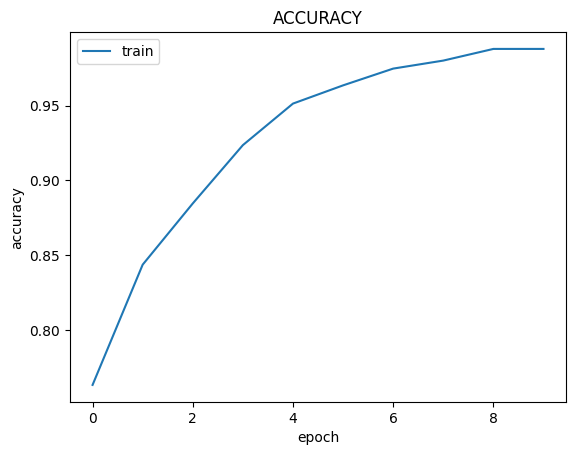

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [24]:
import numpy as np
import pandas as pd
y_pred=model.predict(test_ds)
y_classes=[np.argmax(element) for element in y_pred]
print(y_classes[:10])
print("\nTest")
print(test_labels[:10])

35/35 [==============================] - 287s 8s/step
[2, 3, 3, 4, 3, 0, 0, 0, 0, 1]

Test
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
